In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from os import listdir,chdir
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label
from collections import deque
import pickle

C:\Users\akshatha_holla\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [3]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),spatial_feat=True, 
                        hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

In [7]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] 

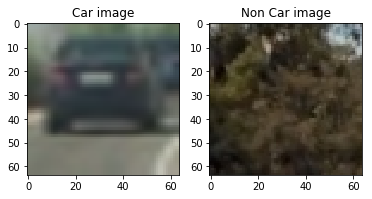

In [8]:

cars=glob.glob('vehicles/*/*.png')
not_cars=glob.glob('non-vehicles/*/*.png')
#print(len(not_cars))
sample_car=mpimg.imread(cars[1])
sample_non_car=mpimg.imread(not_cars[2])
plt.subplot(121)
plt.title("Car image")
plt.imshow(sample_car)
plt.subplot(122)
plt.title("Non Car image")
plt.imshow(sample_non_car)
        
        



   
   

C:\Users\akshatha_holla\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


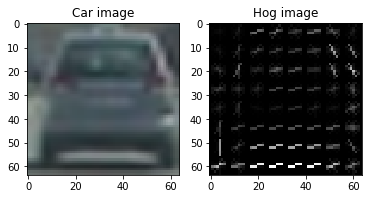

In [9]:
 # Create an array stack of feature vectors
 

car_image = mpimg.imread(cars[3])
#feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2YCrCb)
carfeatures ,car_hog_image = get_hog_features(car_image[:,:,2],orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True)
non_car_image=mpimg.imread(not_cars[3])
notcarfeatures ,not_car_hog_image = get_hog_features(non_car_image[:,:,2],orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True)

plt.subplot(121)
plt.title("Car image")
plt.imshow(car_image)
plt.subplot(122)
plt.title("Hog image")
plt.imshow(car_hog_image, cmap='gray')
# plt.subplot(221)
# plt.title("Non Car image")
# plt.imshow(non_car_image)
# plt.subplot(222)
# plt.title("Hog image")
# plt.imshow(not_car_hog_image, cmap='gray')
# plt.show()
# Plot an example of raw and scaled features

In [10]:

car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(not_cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))
print(len(notcar_features))

C:\Users\akshatha_holla\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


8792
8968


In [11]:

X = np.vstack((car_features, notcar_features)).astype(np.float64)
y= np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


In [12]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

21.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
For these 10 labels:  [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
0.01562 Seconds to predict 10 labels with SVC


In [13]:
#Saving classifier data
classifier_data = {'svc': svc, 'X_scaler': X_scaler, 'color_space': color_space, 'orient': orient,
                       'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'hog_channel': hog_channel,
                       'spatial_size': spatial_size, 'hist_bins': hist_bins, 'spatial_feat': spatial_feat,
                       'hist_feat': hist_feat, 'hog_feat': hog_feat, 'y_start_stop': y_start_stop}

pickle.dump(classifier_data,open('data_dump.p', "wb"))

In [14]:


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [15]:
def find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_history,threshold):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list=[]
    ctrans_tosearch_img = convert_color(img_tosearch, conv='RGB2YCrCb')
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch_img.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        else:
            ctrans_tosearch =ctrans_tosearch_img
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
    
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
              
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
    
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((hog_features, None,None)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                    box_list.append(box)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    heat_history.append(heat)
    heat=np.array(heat_history).sum(axis=0)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)

    return draw_img
    


C:\Users\akshatha_holla\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


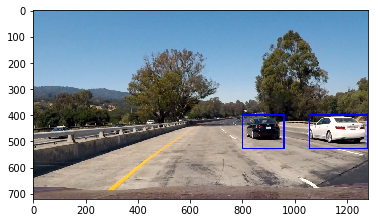

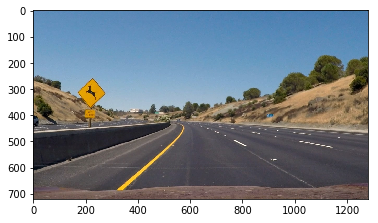

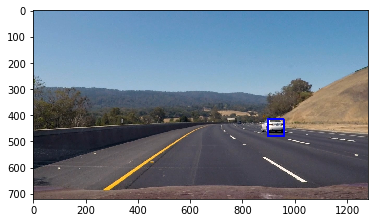

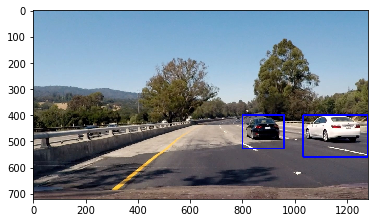

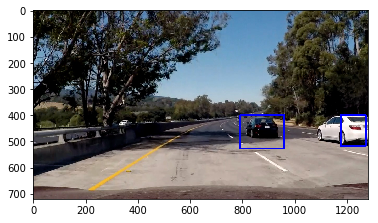

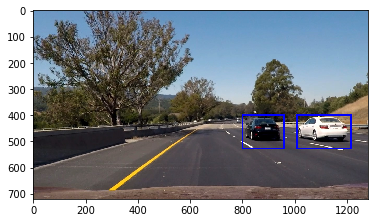

In [16]:
ystart = 400
ystop = 656
scales = [1.0, 1.5, 2.0, 2.5]
heatmap_images_path=("./output_images/heatmap_output/")
classifier_images_path=("./output_images/classifier_output/")
final_images_path=("./output_images/final_output/")
test_images=glob.glob("./test_images/*.jpg")
for image in test_images:
    img=mpimg.imread(image)
    heat_history = deque(maxlen=8)
    threshold=1
    out_img = find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                     heat_history, threshold)
    plt.imshow(out_img)
    #mpimg.imsave(final_images_path+image.split("\\")[-1], out_img)
    plt.show()

In [17]:
def pipeline(img):
    ystart = 400
    ystop = 656
    scales = [1.0, 1.5, 2.0, 2.5]
    heat_history = deque(maxlen=8)
    threshold=1
    out_img = find_cars_with_heatmap(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                     heat_history, threshold)
    return out_img

In [19]:
from moviepy.editor import VideoFileClip
vid_output = 'final_video_output_1.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip("project_video.mp4")#.subclip('00:00:40.00','00:00:43.00') 
#clip1 = VideoFileClip("project_video.mp4")

# NOTE: this function expects color images
vid_clip = clip1.fl_image(pipeline)
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video final_video_output_final.mp4
[MoviePy] Writing video final_video_output_final.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [48:21<00:02,  2.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_video_output_final.mp4 



In [17]:
#classifier_data = pickle.load(open("data_dump.p", "rb"))
#svc = classifier_data['svc']
#svc.score(X_test,y_test)